## Implementing a Hough Transform

The target is to identify the lines in an picture. To do so we use the line equation and identify the paratmeters to another space it is shown in the below image
![image to hough space](images/image2hough.PNG)

Now you know how the Hough Transform works, but to accomplish the task of finding lane lines, we need to specify some parameters to say what kind of lines we want to detect (i.e., long lines, short lines, bendy lines, dashed lines, etc.).

To do this, we'll be using an OpenCV function [called `HoughLinesP`](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html) that takes several parameters. 

### Probabilistic Hough Line Transform

First you apply the transform:
```
    # Probabilistic Line Transform
    linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
```

with the arguments:

- dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)
- lines: A vector that will store the parameters (xstart,ystart,xend,yend) of the detected lines
- rho : The resolution of the parameter r in pixels. We use 1 pixel.
- theta: The resolution of the parameter θ in radians. We use 1 degree (CV_PI/180)
- threshold: The minimum number of intersections to "*detect*" a line
- minLinLength: The minimum number of points that can form a line. Lines with less than this number of points are disregarded.
- maxLineGap: The maximum gap between two points to be considered in the same line.



Let's code it up and find the lane lines in the image we detected edges in with the Canny function (for a look at coding up a Hough Transform from scratch, check this out.) .

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

Prepare the logger for deugging if needed

In [2]:
import logging

# create logger
logger = logging.getLogger(__name__)

#Set level to logging.DEBUG to see CRITICAL, ERROR, WARNING, INFO and DEBUG statements
#Set level to logging.ERROR to see the CRITICAL & ERROR statements only
logger.setLevel(logging.DEBUG)

# create file handler which logs even debug messages
fh = logging.FileHandler('info_out.log')
fh.setLevel(logging.INFO)

# create console handler and set level to debug
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.DEBUG)
#consoleHandler.setLevel(logging.ERROR)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
fh.setFormatter(formatter)
consoleHandler.setFormatter(formatter)

# add ch to logger
logger.addHandler(fh)
logger.addHandler(consoleHandler)


Read in and grayscale the image and then adjust and apply canny function.

2020-09-21 04:38:13,527 - __main__ - INFO - This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


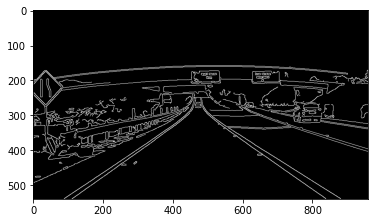

In [62]:
# Read in and grayscale the image
image = mpimg.imread('test_images/exit-ramp.jpg')
logger.info('This image is: %s with dimensions: %s', type(image), image.shape)

gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

if logging.DEBUG >= logger.level:
    plt.imshow(edges, cmap='Greys_r')

Next we'll create a masked edges image using `cv2.fillPoly()`. This time we are defining a four sided polygon to mask

2020-09-21 04:38:21,088 - __main__ - DEBUG - The vertices of the image is: [[[  0 540]
  [490 250]
  [510 250]
  [960 540]]] 


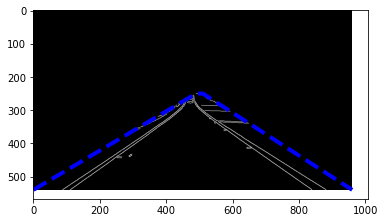

In [63]:
# Return an array of zeros with the same shape and type as a given edges array.
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(490, 250), (510, 250), (imshape[1],imshape[0])]], dtype=np.int32)
logger.debug('The vertices of the image is: %s ',vertices)

cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

if logging.DEBUG >= logger.level:
    plt.imshow(masked_edges, cmap='Greys_r')
    x = [0, 490, 510, imshape[1]]
    y = [imshape[0], 250, 250, imshape[0]]
    plt.plot(x, y, 'b--', lw=4)

### Define the Hough transform parameters
for [`numpy.dstack`](https://numpy.org/doc/stable/reference/generated/numpy.dstack.html?highlight=dstack#numpy.dstack)

I chose parameters for my Hough space grid to be 
- `rho`: 2 pixels 
- `theta`: 1 degree (pi/180 radians). 
- `threshold`: 15, meaning at least 15 points in image space need to be associated with each line segment. 
- `min_line_length`: 50 pixels
- `max_line_gap`: 4 pixels.

With these parameters, I'm picking up the lanes lines and nothing else, so looks like a decent solution!

2020-09-21 04:43:20,987 - __main__ - DEBUG - The number of lines: 13 


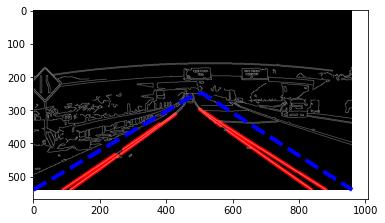

In [65]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50 #minimum number of pixels making up a line
max_line_gap = 4    # maximum gap in pixels between connectable line segments

# Make a blank the same size as our image to draw on
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

logger.debug('The number of lines: %s ',len(lines))

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) # Create image with depth = 3 for colors.

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

if logging.DEBUG >= logger.level:
    plt.imshow(lines_edges)
    plt.plot(x, y, 'b--', lw=4)

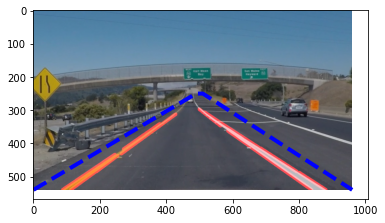

In [66]:
# Draw the lines on the edge image
image_lines = cv2.addWeighted(image, 0.8, line_image, 1, 0) 

if logging.DEBUG >= logger.level:
    plt.imshow(image_lines)
    plt.plot(x, y, 'b--', lw=4)